## Modeling
For this predictive model, our target variable will be "up_votes", which we will use to test the accuracy of model on a holdout subset of testing data, measured by the RMSE value. We also investigate the feature importance of the explantory variables, to determine which features are most impactful in causing a post to receive more "up_votes" (going viral) and what causes the opposite (less/no "up_votes).

Target Variable: "up_votes"

Tokenization: 
- TF-IDF Vectorizor
- Bert Tokenizer

Train-Test-Split: 80/20

Models: 
- Sklearn's Logistic Regression (baseline)
- Sklearn's Elastic Net
- Sklearn's Random Forest
- XgBoost
- Tensorflow's Bert

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from datetime import datetime

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support,classification_report,confusion_matrix

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Eluvio_Challenge/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('Eluvio_DS_Challenge_cleaned_wrangled.csv', index_col=0)

In [ ]:
data.head(2)

,time_created,up_votes,title,over_18,author,clock_time,hour,day_of_week,char_count,word_count,flesch_readability,flesch_grade,month,year
0,2008-01-25 03:34:06,3,Scores killed in Pakistan clashes,False,polar,03:34:06,3,4,33,5,83.32,2.9,1,2008
1,2008-01-25 03:34:35,2,Japan resumes refuelling mission,False,polar,03:34:35,3,4,32,4,33.58,9.6,1,2008


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509236 entries, 0 to 509235
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   time_created        509236 non-null  object 
 1   up_votes            509236 non-null  int64  
 2   title               509236 non-null  object 
 3   over_18             509236 non-null  bool   
 4   author              509236 non-null  object 
 5   clock_time          509236 non-null  object 
 6   hour                509236 non-null  int64  
 7   day_of_week         509236 non-null  int64  
 8   char_count          509236 non-null  int64  
 9   word_count          509236 non-null  int64  
 10  flesch_readability  509236 non-null  float64
 11  flesch_grade        509236 non-null  float64
 12  month               509236 non-null  int64  
 13  year                509236 non-null  int64  
dtypes: bool(1), float64(2), int64(7), object(4)
memory usage: 54.9+ MB


In [ ]:
data = data

### Feature Engineering
For all the model except for the Bert Model, we will use a TF-IDF Vectorizer to convert the "title" column into tokens.

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    text = ' '.join(text)
    return text

title_series = data.title.apply(lemmatize_text)


final_stopwords_list = stopwords.words('english')
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000, 
                                   min_df=0.001, stop_words=final_stopwords_list, 
                                   use_idf=True, ngram_range=(1,2))

In [ ]:
tfidf_X = tfidf_vectorizer.fit_transform(title_series)

In [ ]:
# creating a TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_X.A, columns=tfidf_vectorizer.get_feature_names())

In [ ]:
tfidf_df.head()

,000,000 people,10,10 000,10 year,100,100 000,11,12,13,14,15,150,16,17,18,19,1st,20,200,2008,2009,2010,2011,2012,2013,2014,2015,2016,2020,21,22,23,24,25,26,27,28,30,300,...,without,witness,woman,women,word,work,worker,workers,working,world,world cup,world largest,world news,world war,worldwide,worse,worst,worth,would,wounded,wrong,xi,yahoo,year,year ago,year old,year prison,years,yemen,yemeni,yet,york,young,youth,youtube,yr,zealand,zika,zimbabwe,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dropping Colinear Columns and One-Hot Encoding Categorical Variables of Orginal Dataframe

In [ ]:
data.head()

,time_created,up_votes,title,over_18,author,clock_time,hour,day_of_week,char_count,word_count,flesch_readability,flesch_grade,month,year
0,2008-01-25 03:34:06,3,Scores killed in Pakistan clashes,False,polar,03:34:06,3,4,33,5,83.32,2.9,1,2008
1,2008-01-25 03:34:35,2,Japan resumes refuelling mission,False,polar,03:34:35,3,4,32,4,33.58,9.6,1,2008
2,2008-01-25 03:42:03,3,US presses Egypt on Gaza border,False,polar,03:42:03,3,4,31,6,90.77,2.1,1,2008
3,2008-01-25 03:54:50,1,Jump-start economy: Give health care to all,False,fadi420,03:54:50,3,4,44,7,64.37,6.0,1,2008
4,2008-01-25 15:25:20,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,15:25:20,15,4,47,7,38.99,9.6,1,2008


In [ ]:
data.drop(columns=['time_created', 'title','clock_time', 'author'], inplace=True)

In [ ]:
data = pd.get_dummies(data,columns=['hour','month', 'day_of_week', 'year'],drop_first=True)

In [ ]:
data.head()

,up_votes,over_18,char_count,word_count,flesch_readability,flesch_grade,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
0,3,False,33,5,83.32,2.9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,False,32,4,33.58,9.6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,False,31,6,90.77,2.1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,False,44,7,64.37,6.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,False,47,7,38.99,9.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler

# scaling numeric variables to a mean of 0 with unit variance (std of 1).

scaler = StandardScaler()
data[['up_votes','char_count', 'word_count','flesch_readability','flesch_grade']] = scaler.fit_transform(data[['up_votes','char_count', 'word_count','flesch_readability','flesch_grade']])


In [ ]:
tfidf_X.shape

(509236, 1969)

In [ ]:
from scipy.sparse import hstack,csr_matrix

sparse_data = csr_matrix(data.drop(columns=['over_18']).values)
sparse_data = hstack((sparse_data,tfidf_X))

In [ ]:
col_names = data.columns.tolist() + tfidf_df.columns.tolist()

In [ ]:
data.to_csv('data_with_dummies.csv')

In [ ]:
tfidf_X

<509236x1969 sparse matrix of type '<class 'numpy.float64'>'
	with 3605303 stored elements in Compressed Sparse Row format>

In [ ]:
import scipy.sparse

scipy.sparse.save_npz('tfidf_X.npz', tfidf_X)


In [ ]:
# load additional module
import pickle


with open('tfidf_df_columns.pkl', 'wb') as filehandle:
    pickle.dump(tfidf_df.columns, filehandle)

# Modeling

In [ ]:
import scipy

data =pd.read_csv('data_with_dummies.csv',index_col=0)
tfidf_X = scipy.sparse.load_npz('tfidf_X.npz')

# load additional module
import pickle

with open('tfidf_df_columns.pkl', 'rb') as filehandle:
    # read the data as binary data stream
    col_names = pickle.load(filehandle)

# creating a TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_X.A, columns=col_names)    

In [ ]:
tfidf_df.shape

(509236, 1969)

In [ ]:
data.shape

(509236, 54)

In [ ]:
from sklearn.model_selection import train_test_split

# declaring target variable: y
y = data.over_18.values # up_votes

# creating train test split for TFIDF Vectorizer:
tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(sparse_data, y, test_size=0.25, random_state=42)

NameError: ignored

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(tfidf_X_train, tfidf_y_train)
lr_preds = lr.predict(tfidf_X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
## to use MNM use MIN-MAX scaler instead!

# # instantiating a Multinomial Naive Bayes clasifier:
# count_nb_classifier = MultinomialNB()

# # fitting classifier with Count Vectorizer training data:
# count_nb_classifier.fit(tfidf_X_train, tfidf_y_train)

# # creating predictions on test data:
# count_preds = count_nb_classifier.predict(tfidf_X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time 

start = time.time()
rf = RandomForestClassifier()

rf.fit(tfidf_X_train, tfidf_y_train)
tfidf_rf_preds = rf.predict(tfidf_X_test)
stop = time.time()
print(stop-start)

60.22904348373413


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00    127236
        True       0.00      0.00      0.00        73

    accuracy                           1.00    127309
   macro avg       0.50      0.50      0.50    127309
weighted avg       1.00      1.00      1.00    127309



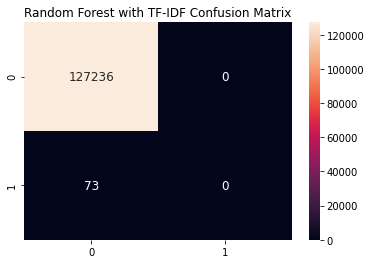

In [ ]:
# Calculate the accuracy score: score
score = classification_report(tfidf_y_test, tfidf_rf_preds)
print(score)

# Calculate the confusion matrix: 
cm = metrics.confusion_matrix(tfidf_y_test, tfidf_rf_preds)
sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 12})
plt.title("Random Forest with TF-IDF Confusion Matrix")
plt.show()

## Modeling Only with Structured Data

In [ ]:
data.head()

,up_votes,over_18,char_count,word_count,flesch_readability,flesch_grade,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
0,-0.201657,False,-0.945477,-0.955200,1.039037,-1.270800,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,-0.203503,False,-0.962227,-1.056396,-0.878085,0.195195,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,-0.201657,False,-0.978977,-0.854003,1.326181,-1.445844,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,-0.205349,False,-0.761226,-0.752806,0.308649,-0.592504,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,-0.199811,False,-0.710976,-0.752806,-0.669569,0.195195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

# declaring target variable: y
y = data.over_18.values # up_votes
X= data.drop(columns=['over_18'])

# creating train test split for TFIDF Vectorizer:
tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(X, y, test_size=0.25, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00    127236
        True       0.00      0.00      0.00        73

    accuracy                           1.00    127309
   macro avg       0.50      0.50      0.50    127309
weighted avg       1.00      1.00      1.00    127309



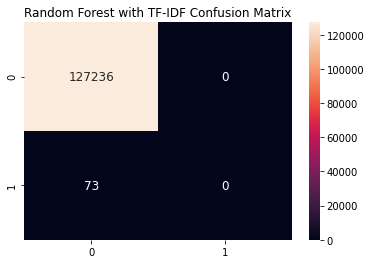

In [ ]:

start = time.time()
rf = RandomForestClassifier()

rf.fit(tfidf_X_train, tfidf_y_train)
tfidf_rf_preds = rf.predict(tfidf_X_test)
stop = time.time()
print(stop-start)

# Calculate the accuracy score: score
score = classification_report(tfidf_y_test, lr_preds)
print(score)

# Calculate the confusion matrix: 
cm = confusion_matrix(tfidf_y_test, lr_preds)
sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 12})
plt.title("Random Forest with TF-IDF Confusion Matrix")
plt.show()

metrics.plot_roc_curve(lr,tfidf_X_test, tfidf_y_test)
plt.show()

28.460295915603638
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    127236
        True       0.00      0.00      0.00        73

    accuracy                           1.00    127309
   macro avg       0.50      0.50      0.50    127309
weighted avg       1.00      1.00      1.00    127309



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


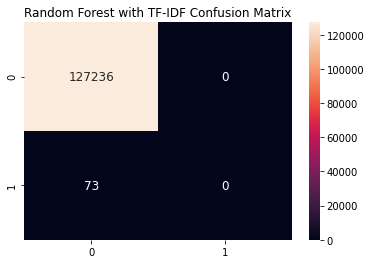

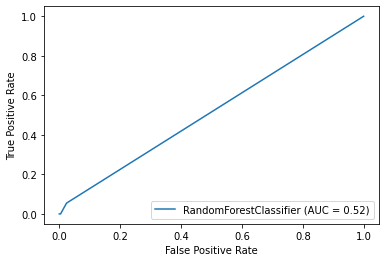

In [ ]:
start = time.time()
rf =  RandomForestClassifier(n_estimators=50, class_weight='balanced')

rf.fit(tfidf_X_train, tfidf_y_train)
tfidf_rf_preds = rf.predict(tfidf_X_test)
stop = time.time()
print(stop-start)

# Calculate the accuracy score: score
score = classification_report(tfidf_y_test, tfidf_rf_preds)
print(score)

# Calculate the confusion matrix: 
cm = confusion_matrix(tfidf_y_test, tfidf_rf_preds)
sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 12})
plt.title("Random Forest with TF-IDF Confusion Matrix")
plt.show()

metrics.plot_roc_curve(rf,tfidf_X_test, tfidf_y_test)
plt.show()

32.81947898864746
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    127236
        True       0.00      0.00      0.00        73

    accuracy                           1.00    127309
   macro avg       0.50      0.50      0.50    127309
weighted avg       1.00      1.00      1.00    127309



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


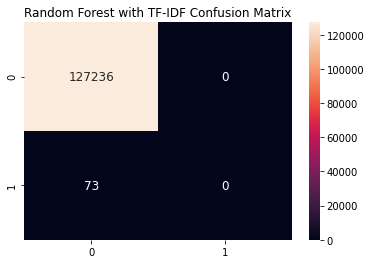

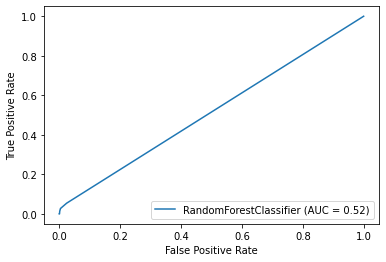

In [ ]:
start = time.time()
rf =  RandomForestClassifier(n_estimators=50, class_weight='balanced_subsample')

rf.fit(tfidf_X_train, tfidf_y_train)
tfidf_rf_preds = rf.predict(tfidf_X_test)
stop = time.time()
print(stop-start)

# Calculate the accuracy score: score
score = classification_report(tfidf_y_test, tfidf_rf_preds)
print(score)

# Calculate the confusion matrix: 
cm = confusion_matrix(tfidf_y_test, tfidf_rf_preds)
sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 12})
plt.title("Random Forest with TF-IDF Confusion Matrix")
plt.show()

metrics.plot_roc_curve(rf,tfidf_X_test, tfidf_y_test)
plt.show()

## Additional EDA for TF-IDF Vectors for Up_Votes/over_18 

In [ ]:
tfidf_df = tfidf_df.sample(n=10000)

In [ ]:
data = data.loc[tfidf_df.index]

In [ ]:
data.head(2)

,up_votes,over_18,char_count,word_count,flesch_readability,flesch_grade,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
7082,-0.207195,False,-0.493225,-0.651610,-0.708497,0.282717,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
214577,-0.207195,False,1.500037,1.878305,0.309035,0.764089,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
tfidf_df.head(2)

,000,000 people,10,10 000,10 year,100,100 000,11,12,13,14,15,150,16,17,18,19,1st,20,200,2008,2009,2010,2011,2012,2013,2014,2015,2016,2020,21,22,23,24,25,26,27,28,30,300,...,without,witness,woman,women,word,work,worker,workers,working,world,world cup,world largest,world news,world war,worldwide,worse,worst,worth,would,wounded,wrong,xi,yahoo,year,year ago,year old,year prison,years,yemen,yemeni,yet,york,young,youth,youtube,yr,zealand,zika,zimbabwe,zone
7082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.head()

,up_votes,over_18,char_count,word_count,flesch_readability,flesch_grade,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
0,-0.201657,False,-0.945477,-0.955200,1.039037,-1.270800,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,-0.203503,False,-0.962227,-1.056396,-0.878085,0.195195,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,-0.201657,False,-0.978977,-0.854003,1.326181,-1.445844,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,-0.205349,False,-0.761226,-0.752806,0.308649,-0.592504,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,-0.199811,False,-0.710976,-0.752806,-0.669569,0.195195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_over_18 = data[data.over_18==True]
data_under_18 = data[data.over_18==False]

In [ ]:
tfidf_df_over_18 = tfidf_df.loc[data_over_18].sum().sort_values(ascending=False)

In [ ]:
tfidf_df_under_18 = tfidf_df.loc[data_under_18].sum().sort_values(ascending=False)

In [ ]:
tfidf_df_under_18.head(30)

china         134.111863
us            128.472316
say           126.241755
syria         113.324307
new           111.254555
russia        103.906236
ha             99.550276
iran           96.066222
attack         95.540402
world          95.075848
police         91.335218
israel         90.863281
killed         85.736250
year           78.790238
war            78.505467
government     73.848913
president      73.353039
india          70.842899
uk             70.071389
korea          67.260023
state          65.813508
ukraine        65.381786
two            64.918264
north          64.243502
russian        64.171255
south          64.069925
people         63.209029
news           61.026882
nuclear        60.910694
military       59.723945
dtype: float64

In [ ]:
tfidf_df_over_18.head(30)

flag          0.678610
chinese       0.653994
see           0.646518
egyptian      0.568060
philippine    0.547101
isis          0.465613
charge        0.457140
sea           0.423488
art           0.418395
face          0.410322
paid          0.400239
leaving       0.396930
best          0.395412
highest       0.392101
known         0.390255
might         0.363365
never         0.358922
real          0.352481
ever          0.351196
price         0.346152
second        0.334690
tv            0.330921
head          0.330080
activist      0.327718
high          0.317483
life          0.295642
million       0.283673
woman         0.279417
ukraine       0.267174
country       0.259217
dtype: float64

In [ ]:
print(data.loc[data_over_18].title.values)

['Pics from the Tibetan protests - more graphic than Wikileaks [nsfw? graphic]'
 'MI5 linked to Max Mosley’s Nazi-style, sadomasochistic sex orgy. Mosley’s father led the British Union of Fascists in the 30s and 40s. His mother was a great admirer of Adolf Hitler.[NSFW]'
 'Tabloid Horrifies Germany: Poland s Yellow Press Turns Blood Red (if you follow the link to the gallery: 4th picture is NSFW in the US)'
 'Love Parade Dortmund: Techno Festival Breaks Record with 1.6 Million (with a 90x90 px NSFW thumbnail)'
 'IDF kills young Palestinian boy. Potentially NSFW.'
 'In pictures: Gaza Massacre (Graphic!  possibly NSFW)'
 'In Pictures: the slaughter of Gazan children Victims of the Israeli occupation forces in the tenth day of their attacks on Gaza Strip.  (Graphic!  NSFW?)'
 'Eye-Opening Montage about the Gaza Massacre (NSFW)'
 'NSFW: Taliban Barbers Frequently Sever Customer s Heads '
 'Famous Russian Female Body Guard Killed in Carjacking [Semi-NSFW Photos]'
 'Woman killed in protests 

In [ ]:
print(data.loc[data_under_18].title.head(100).values)

['Scores killed in Pakistan clashes' 'Japan resumes refuelling mission'
 'US presses Egypt on Gaza border'
 'Jump-start economy: Give health care to all '
 'Council of Europe bashes EU&UN terror blacklist'
 'Hay presto! Farmer unveils the  illegal  mock-Tudor castle he tried to hide behind 40ft hay bales'
 'Strikes, Protests and Gridlock at the Poland-Ukraine Border'
 'The U.N. Mismanagement Program'
 'Nicolas Sarkozy threatens to sue Ryanair '
 'US plans for missile shields in Polish town met with resistance [video]'
 'Archbishop of Canterbury calls for new law to punish  thoughtless or cruel  words -Times Online'
 'Top US Envoy: Violence In Kenya Is  Ethnic Cleansing '
 'Team building float to commemorate the Holocaust in Rio De Jinero has one hell of an idea.'
 'Migrant workers told to abandon Lunar New Year holiday plans'
 ' Sarkozy, Girlfriend Sue Ryanair Over Ad'
 'Nicolas Sarkozy, Angela Merkel confirm their opposition to Turkey being EU membership'
 'Mass Evacuations Continue  

In [ ]:
data_over_18

Int64Index([  1885,   6721,   8414,  12163,  12699,  22288,  22937,  26093,
             35986,  36849,
            ...
            494536, 494947, 499751, 500590, 502531, 503776, 508067, 508176,
            508376, 508706],
           dtype='int64', length=320)

In [ ]:
data_over_18[data_over_18.title.str.contains(pat='NSFW')][['title','over_18']].groupby('over_18').count()

,title
over_18,
True,119


In [ ]:
data_over_18[data_over_18.title.str.contains(pat='NSFW')][['title','over_18']]

,title,over_18
6721,"MI5 linked to Max Mosley’s Nazi-style, sadomas...",True
8414,Tabloid Horrifies Germany: Poland s Yellow Pre...,True
12163,Love Parade Dortmund: Techno Festival Breaks R...,True
12699,IDF kills young Palestinian boy. Potentially N...,True
22288,In pictures: Gaza Massacre (Graphic! possibly...,True
...,...,...
411750,Chinese buyer nabs Modigliani nude for $170.4 ...,True
413444,NSFW Paris attack picture from inside Bataclan...,True
464794,"(Liberia, NSFW) Man, 47, Cuts Off Penis; commi...",True
499751,[Possibly NSFW] BBFC Tapped as New Porn Age-Ve...,True


In [ ]:
data_under_18[data_under_18.title.str.contains(pat='NSFW')][['title','over_18']]

,title,over_18


In [1]:
data_under_18[data_under_18.title.str.contains(pat='kill')][['title','over_18']]['title'].head(20).values

NameError: ignored

In [ ]:
print(data[data.title.str.contains(pat='warning')][['title','over_18']])

                                                    title  over_18
60                    Despite warnings, tornadoes kill 55    False
841     Police have sent out a hoax drugs warning to s...    False
4455    There were early warnings in the weeks and mon...    False
4760    Ship hired by U.S. military fires warning shot...    False
5751    Shellshocked House Republicans get warnings fr...    False
...                                                   ...      ...
507622  YPG to withdraw east of the Euphrates after Tu...    False
508250  Trump election: Baltic warning over Russian mo...    False
509067  7.3 Magnitude Earthquake hits Fukushima, Japan...    False
509106  Japan earthquake: 7.4 magnitude quake prompts ...    False
509155  British Navy fire warning shots at Spanish Nav...    False

[1655 rows x 2 columns]


In [ ]:
print(data[data.title.str.contains(pat='warning', case=False)][['title']].head(20).values)

[['Despite warnings, tornadoes kill 55']
 ['Police have sent out a hoax drugs warning to schools over a fake drug called  strawberry meth ']
 ['Warnings over future food crisis.  A food crisis may hit sooner than climate change ']
 ['Tibet violence <Warning: Graphic Pictures>']
 ['Scientist: CDC Bosses Ignored Warning']
 ['Warning over food price  time bomb ']
 ['Uh oh...  Navy Fires Warning Flare as Iranian Boat Approaches in Persian Gulf ']
 ['There were early warnings in the weeks and months leading up to the massacre in Rwanda. Today, the same warnings are coming out of Zimbabwe.']
 ['Ship hired by U.S. military fires warning shots in Gulf']
 ['Shellshocked House Republicans get warnings from leaders of election disaster in November']
 ['Wash Po:  A Secret Afghanistan Mission Prepares for War with Iran - Early Warning']
 ['Brazil sees no Iranian threat, despite US warning']
 ['Drug Kingpins Issue Warning to Mexican Police Officers & Soldiers -  Join Us or Die  ']
 ['FROG MARCH: Tho

In [ ]:
print(data_under_18[data_under_18.title.str.contains(pat='graphic', case=False)][['title']].head(20).values)

[['Tibet violence <Warning: Graphic Pictures>']
 ['Defusing Germany s Demographic Timebomb']
 ['Hamas bans pornographic websites in Gaza Strip']
 ['Did famine kill 7 million people in USA during the depression? Russian researcher claims the demographic evidence says yes. ']
 [' Indiana Jones  graphics meant to go unnoticed']
 ['What you are going to see in this post is a realistic toilet that was featured under  Cool Inventions  in National Geographic Kids Magazine under the title Souped Up John. ']
 ['very graphic photos and captions of violence at gay rights protest in Russia. Funny thing is, it s hard to tell who s gay and who s just a Russian in a tank top (pics)']
 ['Shark Attack Victim s Butt Bitten Off [Warning Graphic]']
 ['Palestinian protesting the separation fence is shot by the Israeli army using live rounds [graphic video]']
 ['Marine s graphic interview describes killing of Iraqi prisoners']
 ['National Geographic publishes faked photos, Hungarian society says']
 ['Israel

In [ ]:
data[data.title.str.contains(pat='graphic', case=False)]['over_18'].value_counts()

False    555
True      28
Name: over_18, dtype: int64

In [ ]:
data[data.title.str.contains(pat='porn', case=False)]['over_18'].value_counts()

False    877
True       4
Name: over_18, dtype: int64

In [ ]:
print(data_under_18[data_under_18.title.str.contains(pat='porn', case=False)][['title']].head(20).values)

[['Finnish police: Hundreds of public child porn sites in USA']
 ['China asks nicely that Web sites cut out porn, violence, horror and all  backward, decadent thoughts.  Good luck with that.']
 ['Japan to outlaw possession of child pornography']
 ['Innocent Images Takes Down Major Child Porn Ring']
 ['Indonesia block porn websites based on  common sense ']
 ['Feds Charge Porn Producer With Selling Adult Content to Adults']
 ['Fewer than 3,000 websites produce bulk of child porn']
 ['Crazy teacher and coach, Michael Jablonski arrested for child porn']
 ['(UK) Extreme porn  law could criminalise millions']
 ['Japanese official demoted for logging more than 780,000 hits on porn sites']
 ['Ex-priest admits to sharing child pornography with online dominatrix']
 ['(STORY) The Rise And Fall Of An Internet Porn King']
 ['Criminal penalties for child pornography upheld by high court']
 ['Hamas bans pornographic websites in Gaza Strip']
 ['International peacekeepers accused of  significant  chil

In [ ]:
nsfw_series = data.title.apply(lambda x: True if x.isin(nsfw_word_list))


In [ ]:
data['nsfw'] = data.title.str.contains('nsfw|nsfl|graphic|porn|death|warning|kill|torture')


In [ ]:
nsfw_series.value_counts()

False    473091
True      36145
Name: title, dtype: int64

In [ ]:
data

,time_created,up_votes,title,over_18,author,clock_time,hour,day_of_week,char_count,word_count,flesch_readability,flesch_grade,month,year,nsfw
0,2008-01-25 03:34:06,3,Scores killed in Pakistan clashes,False,polar,03:34:06,3,4,33,5,83.32,2.9,1,2008,True
1,2008-01-25 03:34:35,2,Japan resumes refuelling mission,False,polar,03:34:35,3,4,32,4,33.58,9.6,1,2008,False
2,2008-01-25 03:42:03,3,US presses Egypt on Gaza border,False,polar,03:42:03,3,4,31,6,90.77,2.1,1,2008,False
3,2008-01-25 03:54:50,1,Jump-start economy: Give health care to all,False,fadi420,03:54:50,3,4,44,7,64.37,6.0,1,2008,False
4,2008-01-25 15:25:20,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,15:25:20,15,4,47,7,38.99,9.6,1,2008,False
